V=0.00 | I=0.0000e+00 | muP=0.000 | eps=1.000
V=0.08 | I=1.3145e-06 | muP=0.003 | eps=1.000
V=0.17 | I=2.7571e-06 | muP=0.006 | eps=1.000
V=0.25 | I=4.1554e-06 | muP=0.017 | eps=1.000
V=0.34 | I=5.5416e-06 | muP=0.028 | eps=1.000
V=0.42 | I=7.0800e-06 | muP=0.044 | eps=1.000
V=0.51 | I=8.7356e-06 | muP=0.066 | eps=1.000
V=0.59 | I=1.0375e-05 | muP=0.086 | eps=1.000
V=0.68 | I=1.2182e-05 | muP=0.115 | eps=1.000
V=0.76 | I=1.4314e-05 | muP=0.147 | eps=1.000
V=0.85 | I=1.6510e-05 | muP=0.180 | eps=1.000
V=0.93 | I=1.8926e-05 | muP=0.215 | eps=1.000
V=1.02 | I=2.1906e-05 | muP=0.259 | eps=1.000
V=1.10 | I=2.5303e-05 | muP=0.303 | eps=1.000
V=1.19 | I=2.9088e-05 | muP=0.349 | eps=1.000
V=1.27 | I=3.3854e-05 | muP=0.403 | eps=1.000
V=1.36 | I=4.0111e-05 | muP=0.460 | eps=1.000
V=1.44 | I=4.7529e-05 | muP=0.517 | eps=1.000
V=1.53 | I=5.7402e-05 | muP=0.579 | eps=1.000
V=1.61 | I=7.2638e-05 | muP=0.646 | eps=1.000
V=1.69 | I=9.4828e-05 | muP=0.716 | eps=1.000
V=1.78 | I=1.3111e-04 | muP=0.787 

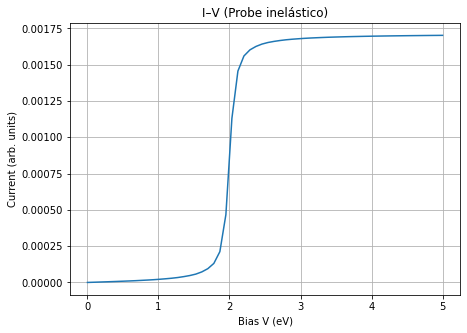

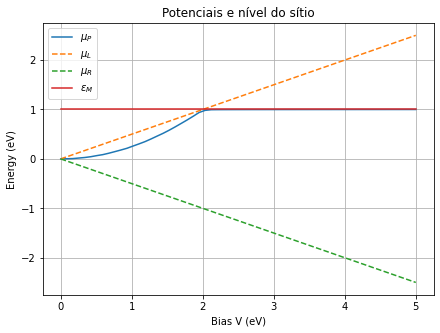

In [13]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt


#  Constantes físicas

kB = 8.617333262e-5   # eV/K
T  = 10.0             # Kelvin (Fig 5.7)
beta = 1/(kB*T)


#  Parâmetros da Tabela 5.1  (Fig 5.7)


eps_L = 0.0
eps_M0 = 1.0
eps_R = 0.0

t_L  = 5.0
t_R  = 5.0
t_ML = 0.1
t_MR = 0.1

gamma_probe = 0.05    # dephasing gammaP

U0 = 0.0              # Hartree (0.0 ou 1.0 depois)

#  Discretização de energia

Emin, Emax = -10.0, 10.0
NE = 2500
Egrid = np.linspace(Emin, Emax, NE)
dE = Egrid[1]-Egrid[0]

eta = 1e-9


#  Funções auxiliares


def fermi(E, mu):
    x = beta*(E-mu)
    x = np.clip(x, -200, 200)     # estabilidade numérica
    return 1.0/(1.0 + np.exp(x))


def self_energy_1D(E, eps, t, tc):
    """
    Autoenergia de uma cadeia 1D semi-infinita
    """
    z = (E-eps)/(2*t)
    z = np.clip(z, -1.0, 1.0)
    k = np.arccos(z)
    Sigma = (tc**2/t) * np.exp(-1j*k)
    return Sigma


def Gamma_from_Sigma(S):
    return -2*np.imag(S)



#  Green function


def Green(E, eps_eff):
    SL = self_energy_1D(E, eps_L, t_L, t_ML)
    SR = self_energy_1D(E, eps_R, t_R, t_MR)
    SP = -1j*gamma_probe/2

    Sigma = SL + SR + SP
    G = 1.0/(E - eps_eff - Sigma + 1j*eta)

    return G, SL, SR



#  Corrente no probe (condição IP = 0)


def probe_current(muP, muL, muR, eps_eff):

    Ip = 0.0

    for E in Egrid:

        G, SL, SR = Green(E, eps_eff)

        GL = Gamma_from_Sigma(SL)
        GR = Gamma_from_Sigma(SR)
        GP = gamma_probe

        fL = fermi(E, muL)
        fR = fermi(E, muR)
        fP = fermi(E, muP)

        TPL = GP * GL * abs(G)**2
        TPR = GP * GR * abs(G)**2

        Ip += (TPL*(fP-fL) + TPR*(fP-fR)) * dE

    return Ip



#  Solver de μP (bisseção estável)

def solve_muP(muL, muR, eps_eff):

    mu_min = muR - 2.0
    mu_max = muL + 2.0

    for _ in range(60):

        mu_mid = 0.5*(mu_min + mu_max)
        I_mid = probe_current(mu_mid, muL, muR, eps_eff)

        if I_mid > 0:
            mu_max = mu_mid
        else:
            mu_min = mu_mid

    return 0.5*(mu_min + mu_max)



#  Ocupação (para Hartree depois)

def occupation(muL, muR, muP, eps_eff):

    n = 0.0

    for E in Egrid:

        G, SL, SR = Green(E, eps_eff)

        GL = Gamma_from_Sigma(SL)
        GR = Gamma_from_Sigma(SR)
        GP = gamma_probe

        fL = fermi(E, muL)
        fR = fermi(E, muR)
        fP = fermi(E, muP)

        A = abs(G)**2 * (GL*fL + GR*fR + GP*fP)
        n += A * dE/(2*pi)

    return n



#  Loop em tensão


Vlist = np.linspace(0, 5.0, 60)

I_list = []
muP_list = []
eps_list = []

n0 = 0.0      # referência Hartree
eps_eff = eps_M0

for V in Vlist:

    muL = +V/2
    muR = -V/2

    
    muP = solve_muP(muL, muR, eps_eff)

    
    I = 0.0
    for E in Egrid:

        G, SL, SR = Green(E, eps_eff)

        GL = Gamma_from_Sigma(SL)
        GR = Gamma_from_Sigma(SR)

        fL = fermi(E, muL)
        fR = fermi(E, muR)

        TLR = GL*GR*abs(G)**2
        I += TLR*(fL-fR)*dE

    
    n = occupation(muL, muR, muP, eps_eff)
    eps_eff = eps_M0 + U0*(n - n0)

    
    I_list.append(I)
    muP_list.append(muP)
    eps_list.append(eps_eff)

    print(f"V={V:.2f} | I={I:.4e} | muP={muP:.3f} | eps={eps_eff:.3f}")



#  Plots


plt.figure(figsize=(7,5))
plt.plot(Vlist, I_list)
plt.xlabel("Bias V (eV)")
plt.ylabel("Current (arb. units)")
plt.title("I–V (Probe inelástico)")
plt.grid()
plt.show()


plt.figure(figsize=(7,5))
plt.plot(Vlist, muP_list, label=r"$\mu_P$")
plt.plot(Vlist, +Vlist/2, "--", label=r"$\mu_L$")
plt.plot(Vlist, -Vlist/2, "--", label=r"$\mu_R$")
plt.plot(Vlist, eps_list, label=r"$\epsilon_M$")
plt.legend()
plt.xlabel("Bias V (eV)")
plt.ylabel("Energy (eV)")
plt.title("Potenciais e nível do sítio")
plt.grid()
plt.show()
